# 12.7. 参数服务器

当我们从一个GPU迁移到多个GPU时，以及再迁移到包含多个GPU的多个服务器时（可能所有服务器的分布跨越了多个机架和多个网络交换机），分布式并行训练算法也需要变得更加复杂。通过细节可以知道，一方面是不同的互连方式的带宽存在极大的区别（例如，NVLink可以通过设置实现跨$6$条链路的高达100GB/s的带宽，16通道的PCIe4.0提供32GB/s的带宽，而即使是高速100GbE以太网也只能提供大约10GB/s的带宽）；另一方面是期望开发者既能完成统计学习建模还精通系统和网络也是不切实际的。

参数服务器的核心思想首先是由 (Smola and Narayanamurthy, 2010)在分布式隐变量模型的背景下引入的。然后，在 (Ahmed et al., 2012)中描述了Push和Pull的语义，又在 (Li et al., 2014)中描述了系统和开源库。下面，我们将介绍用于提高计算效率的组件。

## 12.7.1. 数据并行训练
让我们回顾一下在分布式架构中数据并行的训练方法，因为在实践中它的实现相对简单，因此本节将排除其他内容只对其进行介绍。由于当今的GPU拥有大量的显存，因此在实际场景中（不包括图深度学习）只有数据并行这种并行训练策略值得推荐。图 图12.7.1描述了在 12.5节中实现的数据并行的变体。其中的关键是梯度的聚合需要在单个GPU（GPU 0）上完成，然后再将更新后的参数广播给所有GPU。

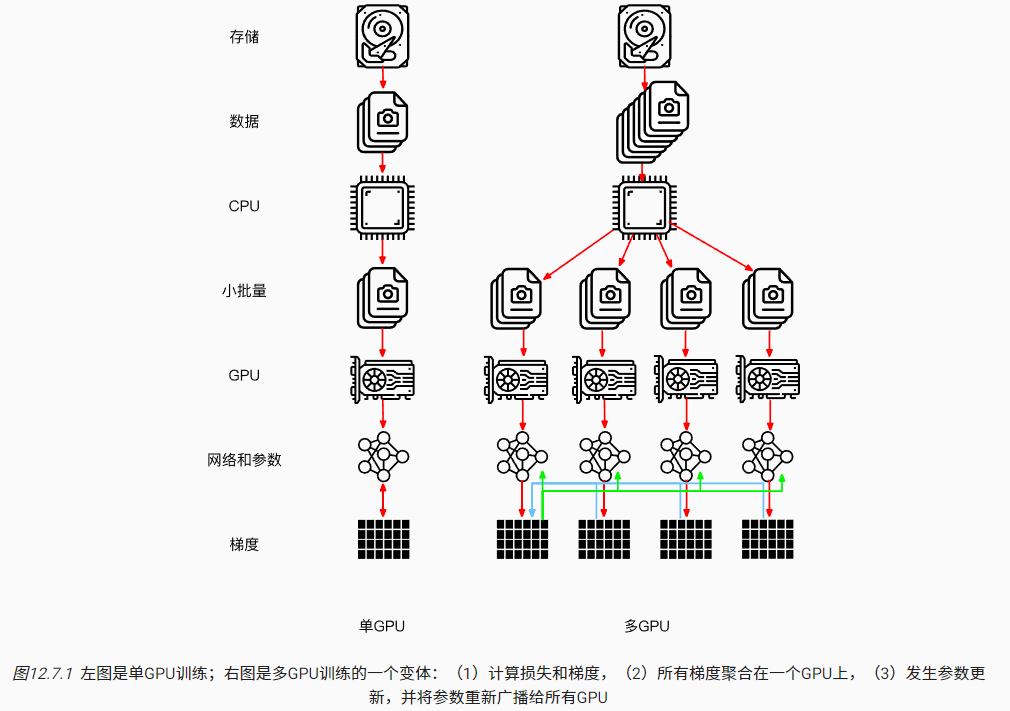

回顾来看，选择GPU 0进行聚合似乎是个很随便的决定，当然也可以选择CPU上聚合，事实上只要优化算法支持，在实际操作中甚至可以在某个GPU上聚合其中一些参数，而在另一个GPU上聚合另一些参数。例如，如果有四个与参数向量相关的梯度$\mathbf{g}_1,\mathbf{g}_2,\mathbf{g}_3,\mathbf{g}_4$，还可以一个GPU对一个$\mathbf{g}_i(i=1,\cdots,4)$）地进行梯度聚合。

这样的推断似乎是轻率和武断的，毕竟数学应该是逻辑自洽的。但是，我们处理的是如 12.4节中所述的真实的物理硬件，其中不同的总线具有不同的带宽。考虑一个如 12.4节中所述的真实的$4$路GPU服务器。如果它的连接是特别完整的，那么可能拥有一个100GbE的网卡。更有代表性的数字是1-10GbE范围内，其有效带宽为100MB/s到1GB/s。因为CPU的PCIe通道太少（例如，消费级的Intel CPU有$24$个通道），所以无法直接与所有的GPU相连接，因此需要multiplexer。CPU在16x Gen3链路上的带宽为16GB/s，这也是每个GPU连接到交换机的速度，这意味着GPU设备之间的通信更有效。

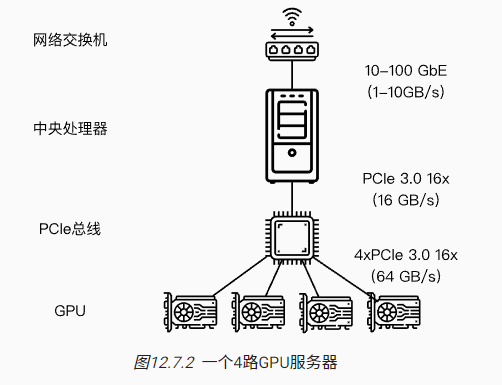

为了便于讨论，我们假设所有梯度共需160MB。在这种情况下，将其中$3$个GPU的梯度发送到第$4$个GPU上需要$30$毫秒（每次传输需要$10$毫秒=160MB/16GB/s）。再加上$30$毫秒将权重向量传输回来，得到的结果是总共需要$60$毫秒。如果将所有的数据发送到CPU，总共需要$80$毫秒，其中将有$40$毫秒的惩罚，因为$4$个GPU每个都需要将数据发送到CPU。最后，假设能够将梯度分为$4$个部分，每个部分为$40$MB，现在可以在不同的GPU上同时聚合每个部分。因为PCIe交换机在所有链路之间提供全带宽操作，所以传输需要$2.5 \times 3 = 7.5$毫秒，而不是$30$毫秒，因此同步操作总共需要$15$毫秒。简而言之，一样的参数同步操作基于不同的策略时间可能在$15$毫秒到$80$毫秒之间。 图12.7.3描述了交换参数的不同策略。

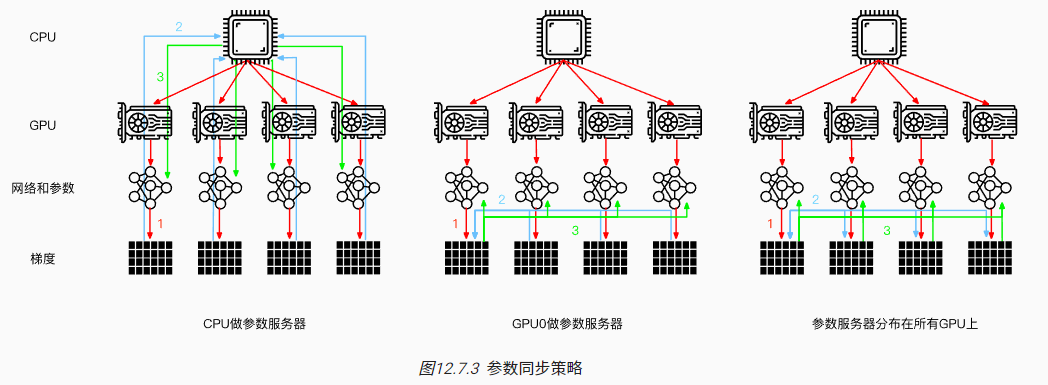

请注意，我们还可以使用另一个工具来改善性能：在深度网络中，从顶部到底部计算所有梯度需要一些时间，因此即使还在忙着为某些参数计算梯度时，就可以开始为准备好的参数同步梯度了。想了解详细信息可以参见 (Sergeev and Del Balso, 2018)，想知道如何操作可参考Horovod。

## 12.7.2. 环同步（Ring Synchronization）
当谈及现代深度学习硬件的同步问题时，我们经常会遇到大量的定制的网络连接。例如，AWS p3.16xlarge和NVIDIA DGX-2实例中的连接都使用了 图12.7.4中的结构。每个GPU通过PCIe链路连接到主机CPU，该链路最多只能以16GB/s的速度运行。此外，每个GPU还具有$6$个NVLink连接，每个NVLink连接都能够以300Gbit/s进行双向传输。这相当于每个链路每个方向约$300 \div 8 \div 2 \approx 18GB/s$
。简言之，聚合的NVLink带宽明显高于PCIe带宽，问题是如何有效地使用它。

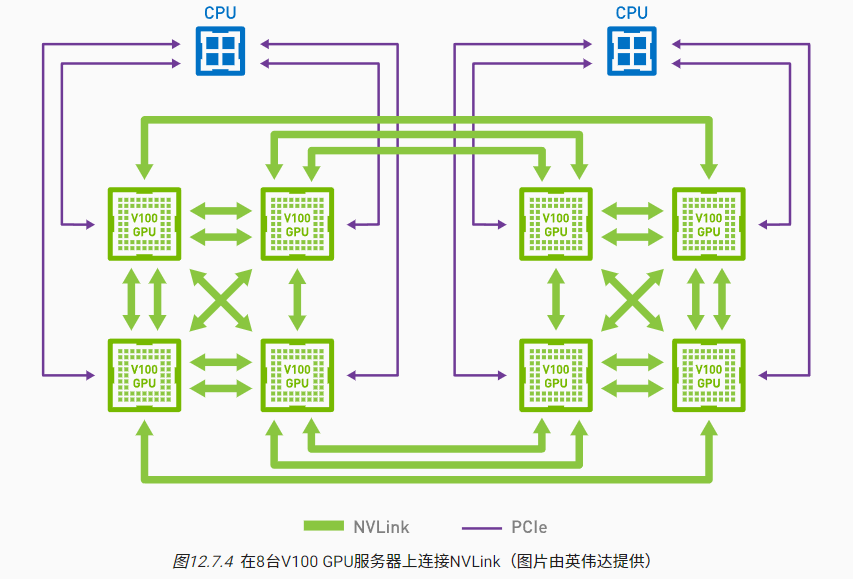

(Wang et al., 2018)的研究结果表明最优的同步策略是将网络分解成两个环，并基于两个环直接同步数据。 图12.7.5描述了网络可以分解为一个具有双NVLink带宽的环（1-2-3-4-5-6-7-8-1）和一个具有常规带宽的环（1-4-6-3-5-8-2-7-1）。在这种情况下，设计一个高效的同步协议是非常重要的

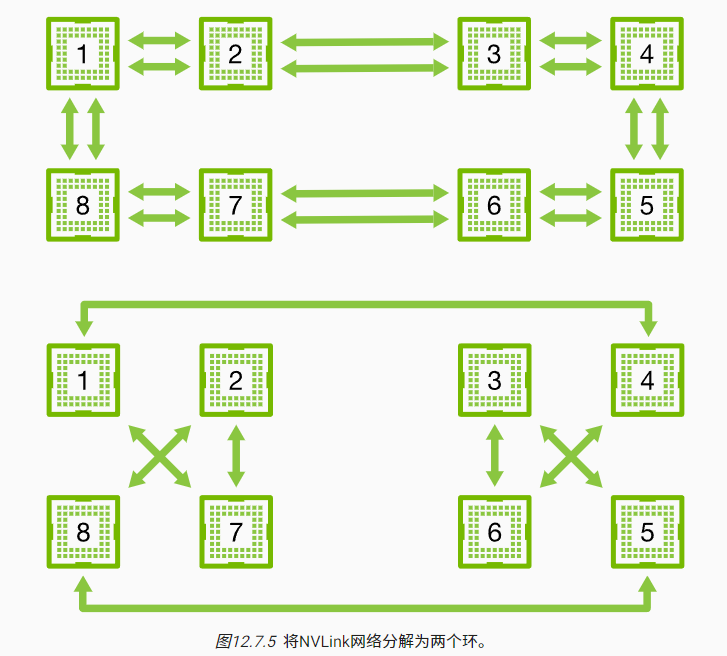

考虑下面的思维试验：给定由$n$个计算节点（或GPU）组成的一个环，梯度可以从第一个节点发送到第二个节点，在第二个结点将本地的梯度与传送的梯度相加并发送到第三个节点，依此类推。在$n-1$步之后，可以在最后访问的节点中找到聚合梯度。也就是说，聚合梯度的时间随节点数线性增长。但如果照此操作，算法是相当低效的。归根结底，在任何时候都只有一个节点在通信。如果我们将梯度分为$n$个块，并从节点$i$开始同步块$i$，会怎么样？因为每个块的大小是$1/n$，所以总时间现在是$(n-1)/n \approx 1$。换句话说，当我们增大环的大小时，聚合梯度所花费的时间不会增加。这是一个相当惊人的结果。 图12.7.6说明了$n=4$个节点上的步骤顺序。

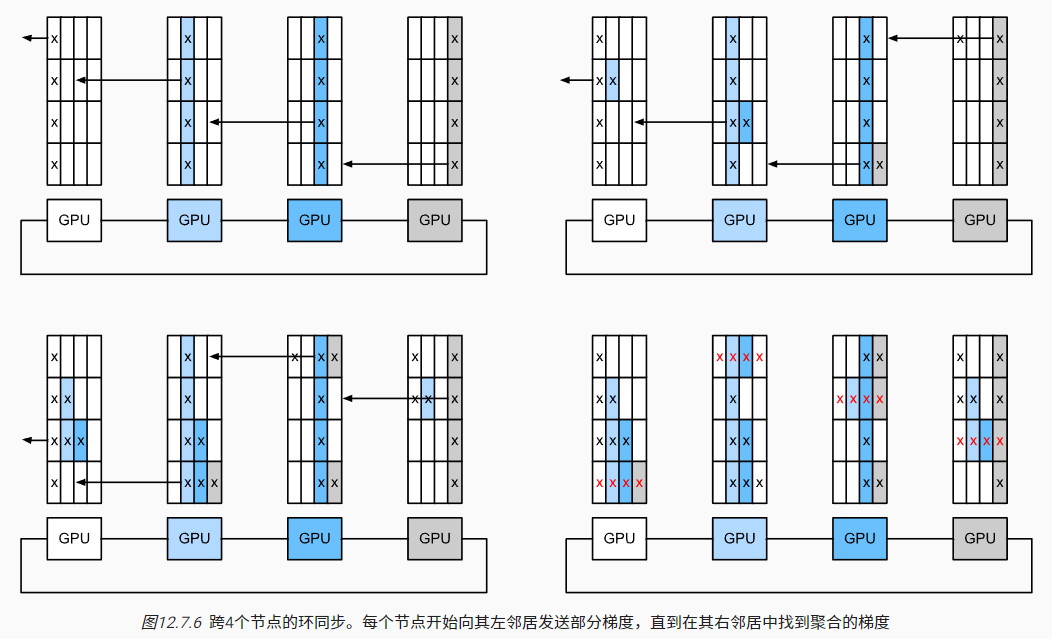

如果我们使用相同的例子，跨$8$个V100 GPU同步160MB，我们得到的结果大约是$2 \times 160MB \div (3 \times 18GB/s) \approx 6ms$。这比使用PCIe总线要好，即使我们现在使用的是$8$个GPU。请注意，这些数字在实践中通常会差一些，因为深度学习框架无法将通信组合成大的突发传输。

注意到有一种常见的误解认为环同步与其他同步算法在本质上是不同的，实际上与简单的树算法相比其唯一的区别是同步路径稍微精细一些。

## 12.7.3. 多机训练
新的挑战出现在多台机器上进行分布式训练：我们需要服务器之间相互通信，而这些服务器又只通过相对较低的带宽结构连接，在某些情况下这种连接的速度可能会慢一个数量级，因此跨设备同步是个棘手的问题。毕竟，在不同机器上运行训练代码的速度会有细微的差别，因此如果想使用分布式优化的同步算法就需要同步（synchronize）这些机器。 图12.7.7说明了分布式并行训练是如何发生的。

1. 在每台机器上读取一组（不同的）批量数据，在多个GPU之间分割数据并传输到GPU的显存中。基于每个GPU上的批量数据分别计算预测和梯度。
2. 来自一台机器上的所有的本地GPU的梯度聚合在一个GPU上（或者在不同的GPU上聚合梯度的某些部分）。
3. 每台机器的梯度被发送到其本地CPU中。
4. 所有的CPU将梯度发送到中央参数服务器中，由该服务器聚合所有梯度。
5. 然后使用聚合后的梯度来更新参数，并将更新后的参数广播回各个CPU中。
6. 更新后的参数信息发送到本地一个（或多个）GPU中。
7. 所有GPU上的参数更新完成。

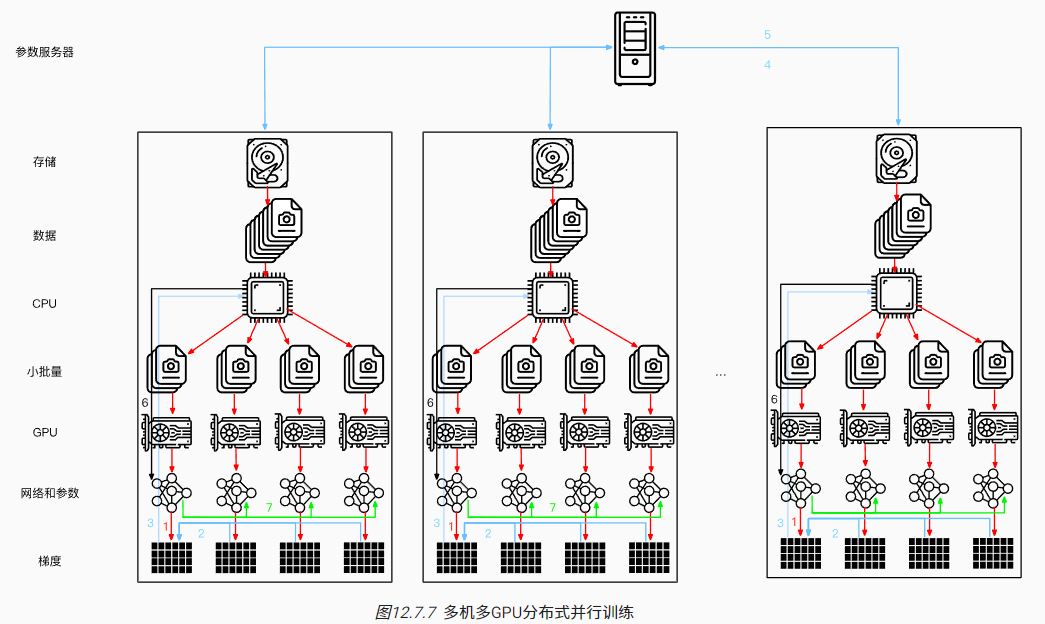

以上这些操作似乎都相当简单，而且事实上它们可以在一台机器内高效地执行，但是当我们考虑多台机器时，就会发现中央的参数服务器成为了瓶颈。毕竟，每个服务器的带宽是有限的，因此对$m$个工作节点来说，将所有梯度发送到服务器所需的时间是$O(m)$。我们也可以通过将参数服务器数量增加到$n$来突破这一障碍。此时，每个服务器只需要存储$O(1/n)$个参数，因此更新和优化的总时间变为$O(m/n)$。这两个数字的匹配会产生稳定的伸缩性，而不用在乎我们需要处理多少工作节点。在实际应用中，我们使用同一台机器既作为工作节点还作为服务器。设计说明请参考 图12.7.8（技术细节请参考 (Li et al., 2014)）。特别是，确保多台机器只在没有不合理延迟的情况下工作是相当困难的。

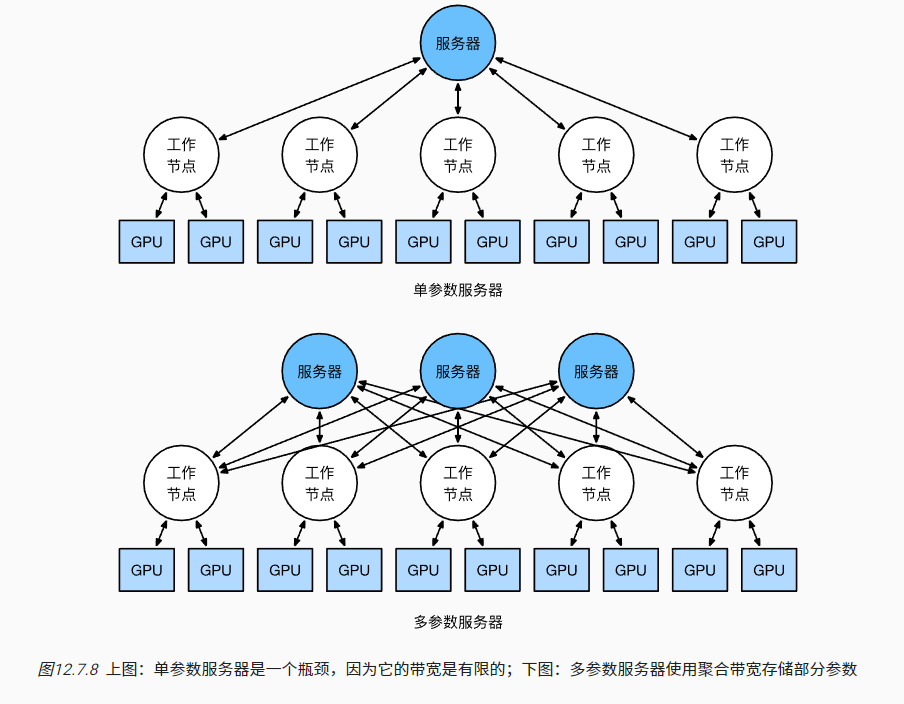

## 12.7.4. 键值存储
在实践中，实现分布式多GPU训练所需要的步骤绝非易事。这就是公共抽象值得使用的原因，公共抽象即重新定义具有更新语义的键－值存储（key-value store）的抽象。

在许多工作节点和许多GPU中，梯度$i$的计算可以定义为
$$\mathbf{g}_i = \sum_{k \in workers}\sum_{j \in GPUs}\mathbf{g}_{ijk}, \tag{12.7.1}$$
 
 
其中$\mathbf{g}_{ijk}$是在工作节点$k$的GPU$j$上拆分的梯度$i$的一部分。这个运算的关键在于它是一个交换归约（commutative reduction），也就是说，它把许多向量变换成一个向量，而运算顺序在完成向量变换时并不重要。这对实现我们的目标来说是非常好的，因为不需要为何时接收哪个梯度进行细粒度的控制。此外，请注意，这个操作在不同的$i$之间是独立的。

这就允许我们定义下面两个操作：push（用于累积梯度）和pull（用于取得聚合梯度）。因为我们有很多层，也就有很多不同的梯度集合，因此需要用一个键$i$来对梯度建索引。这个与Dynamo (DeCandia et al., 2007)中引入的键－值存储之间存在相似性并非巧合。它们两个定义都拥有许多相似的性质，特别是在多个服务器之间分发参数时。

键－值存储的push与pull操作描述如下：

- push（key，value）将特定的梯度值从工作节点发送到公共存储，在那里通过某种方式（例如，相加）来聚合值；
- pull（key，value）从公共存储中取得某种方式（例如，组合来自所有工作节点的梯度）的聚合值。

通过将同步的所有复杂性隐藏在一个简单的push和pull操作背后，我们可以将统计建模人员（他们希望能够用简单的术语表达优化）和系统工程师（他们需要处理分布式同步中固有的复杂性）的关注点解耦。

## 12.7.5. 小结
- 同步需要高度适应特定的网络基础设施和服务器内的连接，这种适应会严重影响同步所需的时间。
- 环同步对于p3和DGX-2服务器是最佳的，而对于其他服务器则未必。
- 当添加多个参数服务器以增加带宽时，分层同步策略可以工作的很好。

## 12.7.6. 练习
1. 请尝试进一步提高环同步的性能吗。（提示：可以双向发送消息。）
2. 在计算仍在进行中，可否允许执行异步通信？它将如何影响性能？
3. 怎样处理在长时间运行的计算过程中丢失了一台服务器这种问题？尝试设计一种容错机制来避免重启计算这种解决方案？